# Compare fit results to published values

This notebook compares fit results from SNCosmo with fit results published by SDSS and DES.

In [1]:
import numpy as np
import sncosmo
from astropy.table import Table, join
from matplotlib import pyplot as plt

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import Span, HoverTool, ColumnDataSource
from bokeh.layouts import gridplot
from tqdm import tqdm

import sys; sys.path.insert(0, '../')
from data_access import sdss_data, des_data

In [2]:
# Set up bokeh plotting
output_notebook()
_basic_tools = "save,pan,box_zoom,reset,wheel_zoom".split(',')


Loading BokehJS ...

## Plotting functions

Since we will be creating the same plots for multiple data sets, we create some generic plotting functions. We create a static version of the plot zoomed in to show detail, along with an interactive version that defaults to show all available data. Note that we assume the colum names of the data tables being plotted.

In [3]:
def create_static_figure(fit_data, survey_name):
    """Return a matplotlib figure comparing x0, x1, c, and chisq
    of the published and SNCosmo fit values.
    
    Args:
        fit_data  (Table): A table of data to plot
        survey_name (str): Name of the survey being plotted
        
    Returns:
         A matplotlib figure object
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    line = (-20, 2000)

    for axis, value in zip(axes, ['x0', 'x1', 'c']):
        axis.plot(line, line, linestyle='--', color='grey')
        axis.errorbar(fit_data['{}_{}'.format(value, survey_name)], 
                      fit_data['{}_sncosmo'.format(value)], 
                      xerr=fit_data['{}_{}_err'.format(value, survey_name)],
                      yerr=fit_data['{}_err_sncosmo'.format(value)], 
                      linestyle='',
                      alpha=.3)

    
    reduced_chisq_survey = fit_data['chisq_{}'.format(survey_name)] / fit_data['ndof_{}'.format(survey_name)]
    reduced_chisq_sncosmo = fit_data['chisq_sncosmo'] / fit_data['ndof_sncosmo']
    axes[3].plot(line, line, linestyle='--', color='grey', alpha=.8)
    axes[3].scatter(fit_data['chisq_{}'.format(survey_name)], 
                    fit_data['chisq_sncosmo'], 
                    alpha=.3, s=10)
    
    axes[4].plot(line, line, linestyle='--', color='grey', alpha=.8)
    axes[4].scatter(reduced_chisq_survey, 
                    reduced_chisq_sncosmo, 
                    alpha=.3, s=10)

    axes[0].set_title('x0')
    axes[0].set_ylabel('SNCosmo Fit ugriz')

    axes[1].set_title('x1')

    axes[2].set_title('c')
    axes[2].set_xlabel('Published Value')
    axes[2].set_ylabel('SNCosmo Fit ugriz')

    axes[3].set_xlabel('Published Value')
    axes[3].set_title('chisq')
    
    axes[4].set_xlabel('Published Value')
    axes[4].set_title('chisq_norm')
    
    return axes


def create_interactive_figure(fit_data, survey_name):
    """Return a bokeh figure comparing x0, x1, c, and chisq
    of the published and SNCosmo fit values.
    
    Args:
        fit_data  (Table): A table of data to plot
        survey_name (str): Name of the survey being plotted
        
    Returns:
         A bokeh figure object
    """
    
    data_dict = {col.name: np.array(col) for col in fit_data.itercols()}
    data_dict['chisq_norm_sncosmo'] = data_dict['chisq_sncosmo'] / data_dict['ndof_sncosmo']
    data_dict['chisq_norm_{}'.format(survey_name)] = data_dict['chisq_{}'.format(survey_name)] / data_dict['ndof_{}'.format(survey_name)]
    source = ColumnDataSource(data=data_dict)

    hover = HoverTool(tooltips=[
            ("target", "@cid"),
            ("class", "@class"),
            ("z", "@z"),
            ('z_fit', '@fit_z'),
            ('chi2', '@chi'),
            ('dof', '@dof'),
        ])

    figures = []
    for value in ('x0', 'x1', 'c', 'chisq_norm'):
        fig = figure(tools=_basic_tools + [hover, 'box_select', 'lasso_select'], title=value)
        fig.circle('{}_{}'.format(value, survey_name), 
                   '{}_sncosmo'.format(value), 
                   source=source, size=4, alpha=.5)
        
        fig.xaxis.axis_label = 'Published Value'
        fig.yaxis.axis_label = 'SNCosmo Fit ugriz'
        figures.append(fig)
    
    return gridplot(figures, ncols=2, plot_width=350, plot_height=350)


## SDSS

We create a table to store both the published and SNCosmo fit results for SDSS. Then we plot correlations between both data sets for the fit parameters x0, x1 (stretch), and c (color) along with normalized chi-squared.

In [4]:
# Get SDSS published data
sdss_published = sdss_data.master_table[
    'CID',
    'x0SALT2zspec', 
    'x0errSALT2zspec', 
    'x1SALT2zspec', 
    'x1errSALT2zspec', 
    'cSALT2zspec', 
    'cerrSALT2zspec',
    'chi2SALT2zspec',
    'ndofSALT2zspec'
]

# Rename columns for consistancy
sdss_published.rename_column('CID', 'cid')
sdss_published.rename_column('x0SALT2zspec', 'x0_sdss')
sdss_published.rename_column('x0errSALT2zspec', 'x0_sdss_err')
sdss_published.rename_column('x1SALT2zspec', 'x1_sdss')
sdss_published.rename_column('x1errSALT2zspec', 'x1_sdss_err')
sdss_published.rename_column('cSALT2zspec', 'c_sdss')
sdss_published.rename_column('cerrSALT2zspec', 'c_sdss_err')
sdss_published.rename_column('chi2SALT2zspec', 'chisq_sdss')
sdss_published.rename_column('ndofSALT2zspec', 'ndof_sdss')

# Get SNCosmo fit data
sdss_sncosmo = Table.read('../sncosmo/sdss_results/snia_ugriz.csv')
sdss_sncosmo.rename_column('x0', 'x0_sncosmo')
sdss_sncosmo.rename_column('x0_err', 'x0_err_sncosmo')
sdss_sncosmo.rename_column('x1', 'x1_sncosmo')
sdss_sncosmo.rename_column('x1_err', 'x1_err_sncosmo')
sdss_sncosmo.rename_column('c', 'c_sncosmo')
sdss_sncosmo.rename_column('c_err', 'c_err_sncosmo')
sdss_sncosmo.rename_column('chi', 'chisq_sncosmo')
sdss_sncosmo.rename_column('dof', 'ndof_sncosmo')

# Combine tables and keep only SN with published fits
combined_sdss = join(sdss_sncosmo, sdss_published)
combined_sdss = combined_sdss[~combined_sdss['x0_sdss'].mask]   
combined_sdss[:5].show_in_notebook()


idx,cid,class,num_points_sdssu,num_points_sdssg,num_points_sdssr,num_points_sdssi,num_points_sdssz,fit_z,z,t0,x0_sncosmo,x1_sncosmo,c_sncosmo,z_err,t0_err,x0_err_sncosmo,x1_err_sncosmo,c_err_sncosmo,chisq_sncosmo,ndof_sncosmo,message,x0_sdss,x0_sdss_err,x1_sdss,x1_sdss_err,c_sdss,c_sdss_err,chisq_sdss,ndof_sdss
0,694,Unknown,35,37,38,38,38,0,0.127493,53623.77216146062,4.504195124901735e-05,0.8525009696882381,0.33541832755726647,nan,6.076528734411113e-05,5.847310908768368e-07,0.14318704480817337,0.011602271088007623,1015.5583713366084,144.0,Covariance may not be accurate.,0.000216,1.09e-05,1.38,0.21,0.23,0.03,186.2,73
1,703,zSNIa,0,22,22,22,22,0,0.298042,53626.53110716466,1.3151371107380975e-05,0.6204574269043099,0.03213617751661113,nan,0.6068512287311023,6.109624932124469e-07,0.6080196089738518,0.038788399266561836,76.16388097948105,84.0,Minimization exited successfully.,5.43e-05,3.47e-06,0.73,0.63,-0.01,0.05,40.8,59
2,716,zSNII,0,42,41,42,39,0,0.324,53640.45447458493,2.918253410371803e-05,10.511512231276527,-0.026919814846107788,nan,0.14654674506891752,4.536177180741453e-07,0.30595805650903807,0.0071300607934545925,2599.733406984297,160.0,Minimization exited successfully.,0.000167,4.38e-06,5.0,0.01,-0.11,0.02,794.1,131
3,717,Unknown,20,20,0,20,20,0,0.130392,53606.73130810018,7.911690166848315e-06,0.5745366571981291,0.9588529905681668,nan,0.0020899035152979195,8.48861681593332e-06,1.5829254431541135,0.5419947790474516,68.78051373886461,56.0,Covariance may not be accurate.,2.24e-05,4.01e-06,0.69,1.05,0.98,0.11,36.2,41
4,735,zSNIa,20,21,20,20,21,0,0.190858,53610.741947364426,2.3046325820095966e-05,-2.5645535823024708,0.024691058937044267,nan,0.0009846973480307497,1.4834865953930549e-06,0.4169127372878672,0.059408219959235356,76.2610493593063,77.0,Covariance may not be accurate.,8.82e-05,1.23e-05,-2.66,0.58,0.01,0.09,20.6,33


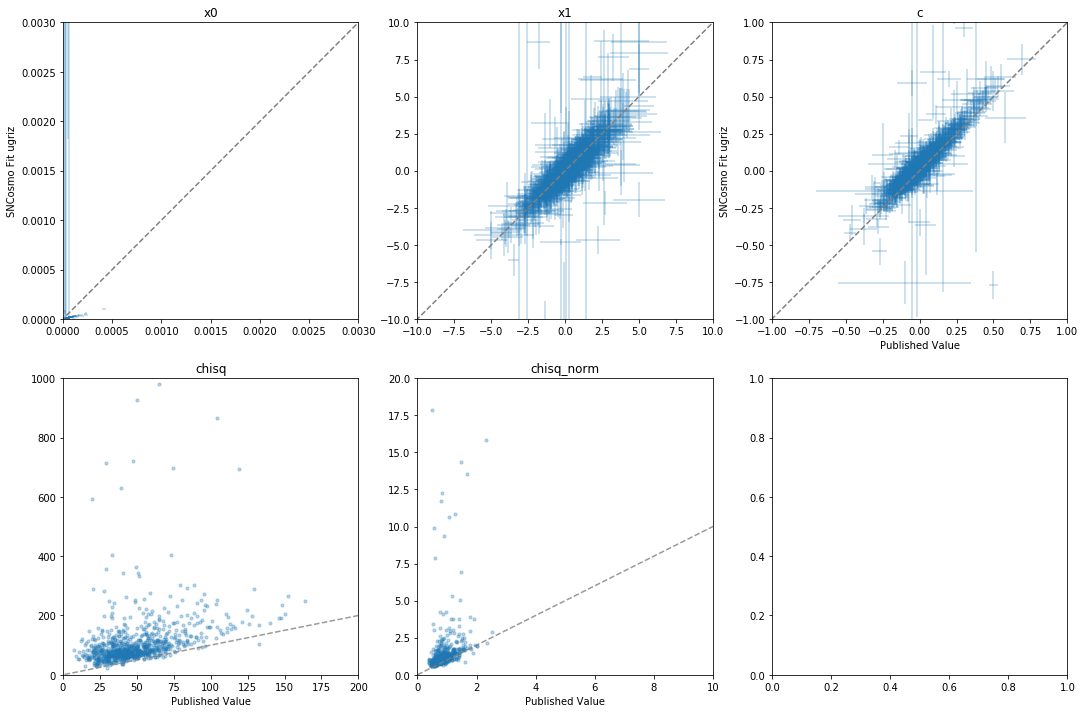

In [71]:
# Consider only type 1a objects
fit_data = combined_sdss[combined_sdss['class'] == 'zSNIa']
plot_axes = create_static_figure(fit_data, 'sdss')

plot_axes[0].set_xlim(0, .003)
plot_axes[0].set_ylim(0, .003)
plot_axes[1].set_xlim(-10, 10)
plot_axes[1].set_ylim(-10, 10)
plot_axes[2].set_xlim(-1, 1)
plot_axes[2].set_ylim(-1, 1)
plot_axes[3].set_xlim(0, 200)
plot_axes[3].set_ylim(0, 1000)
plot_axes[4].set_xlim(0, 10)
plot_axes[4].set_ylim(0, 20)

plt.show()

In [73]:
plot_grid = create_interactive_figure(fit_data, 'sdss')
show(plot_grid)


In [14]:
@np.vectorize
def band_to_offset(band):
    if band == 'sdssu':
        return -0.679
    
    elif band == 'sdssg':
        return 0.0203
    
    elif band == 'sdssr':
        return 0.0049
    
    elif band == 'sdssi':
        return 0.0178
    
    elif band == 'sdssz':
        return 0.0102
    
    raise ValueError('Unknown band {}'.format(band))
    
    
@np.vectorize
def band_to_zp(band):
    if band == 'sdssu':
        return 24.63
    
    elif band == 'sdssg':
        return 25.11
    
    elif band == 'sdssr':
        return 24.80
    
    elif band == 'sdssi':
        return 24.36
    
    elif band == 'sdssz':
        return 22.83
    
    raise ValueError('Unknown band {}'.format(band))
    

In [78]:
test_id = 20489

input_data = sdss_data.get_data_for_id(test_id)
sdss_bands = ('sdssu', 'sdssg', 'sdssr', 'sdssi', 'sdssz')

input_data.show_in_notebook()


idx,FLAG,MJD,FILT,MAG,MERR,MSKYERR,MGALERR,FLUX,FLUXERR,SKYERR,GALERR,NPRE,TELE,RUN,STRIP,IDCCD
0,33,54347.418316,1,24.797,1.277,0.683,0.852,0.1917,0.9509,0.4198,0.5239,12,sdss,6930,82S,6
1,32,54347.414998,2,24.11,1.103,0.454,0.873,0.5912,1.136,0.4388,0.845,14,sdss,6930,82S,6
2,0,54347.415828,3,25.893,0.619,0.239,0.518,-2.477,1.494,0.6164,1.333,13,sdss,6930,82S,6
3,32,54347.417486,4,22.496,0.795,0.693,1.15,1.668,4.364,3.543,5.883,11,sdss,6930,82S,6
4,9,54347.416657,0,22.468,0.795,0.606,0.641,3.911,2.522,2.206,2.332,8,sdss,6930,82S,6
5,0,54357.393936,1,25.527,0.698,0.045,0.512,-0.2467,0.4616,0.02815,0.3231,12,sdss,6955,82S,6
6,32,54357.390618,2,23.85,0.642,0.261,0.354,0.8615,0.7114,0.2941,0.3987,14,sdss,6955,82S,6
7,0,54357.391448,3,25.165,0.737,0.098,0.42,-1.04,1.126,0.1496,0.6403,13,sdss,6955,82S,6
8,32,54357.393107,4,22.474,0.652,0.435,0.66,1.781,3.511,2.241,3.395,11,sdss,6955,82S,6
9,8,54357.392277,0,25.117,1.131,0.917,1.217,-0.4501,1.349,0.9625,1.277,8,sdss,6955,82S,6


In [79]:

input_table = Table()
input_table.meta = input_data.meta
input_table['time'] = input_data['MJD']
input_table['band'] = [sdss_bands[i] for i in input_data['FILT']]
input_table['zp'] = band_to_zp(input_table['band'])

mag = input_data['MAG'] + band_to_offset(input_table['band'])
mag_err = input_data['MERR'] + band_to_offset(input_table['band'])

input_table['flux'] = 10**((mag - input_table['zp']) / -2.5)
input_table['fluxerr'] = 10**((mag_err - input_table['zp']) / -2.5)

input_table['zpsys'] = np.full(len(input_data), 'ab')

print(input_table)
print('\n')

# Get published values
published_values = sdss_published[sdss_published['cid'] == test_id]
x0 = published_values['x0_sdss'][0]
x1 = published_values['x1_sdss'][0]
c = published_values['c_sdss'][0]
chisq_norm = published_values['chisq_sdss'][0] / published_values['ndof_sdss'][0]

print('Published Values for {}:'.format(test_id))
print('x0: ', x0)
print('x1: ', x1)
print('c: ', c)
print('chisq: ', published_values['chisq_sdss'][0])
print('ndof: ', published_values['ndof_sdss'][0])
print('chisq_norm: ', chisq_norm)


    time      band   zp          flux             fluxerr       zpsys
------------ ----- ----- ------------------- ------------------ -----
54347.418316 sdssg 25.11  1.3094231054348415  3350271477.553742    ab
54347.414998 sdssr  24.8  1.8794899162501693 2998057790.1934752    ab
54347.415828 sdssi 24.36 0.23970660446256323 3085176395.9112973    ab
54347.417486 sdssz 22.83  1.3474727773301984  645535306.0839599    ab
54347.416657 sdssu 24.63  13.689891307007318  6391458891.858142    ab
54357.393936 sdssg 25.11  0.6684670424078099  5710577107.450275    ab
54357.390618 sdssr  24.8   2.388031218588031   4583951352.46163    ab
54357.391448 sdssi 24.36  0.4686838621153274  2767451381.845408    ab
54357.393107 sdssz 22.83   1.375054779639723  736410547.1396145    ab
54357.392277 sdssu 24.63  1.1934383792107919  4690293284.059364    ab
         ...   ...   ...                 ...                ...   ...
  54418.3486 sdssu 24.63   0.602004863684458  4596211446.660011    ab
54422.354592 sdssg 2

In [80]:
print('\n\nFitting for all terms except z:')
source = sncosmo.get_source('salt2', version='2.0')
model = sncosmo.Model(source=source)
model.set(z=input_table.meta['redshift'])

result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0', 'x0', 'x1', 'c'], bounds=None)
result['chi2_norm'] = (result.chisq / result.ndof)
sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
plt.show()
print(result)

print('\n\nFitting with fixed, published values:')
model.set(z=input_table.meta['redshift'], x0=x0, x1=x1, c=c)
result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0'], bounds=None)
result['chi2_norm'] = (result.chisq / result.ndof)
sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
plt.show()
print(result)
print('\n\n\n')




Fitting for all terms except z:


DataQualityError: No data points with S/N > 5.0. Initial guessing failed.

## DES

As before, we create a table to store both the published and SNCosmo fit results and plot the correlation.

In [ ]:
# Get DES published data
des_published = des_data.master_table[
    'CID',
    'x0',
    'x0ERR',
    'x1',
    'x1ERR',
    'c',
    'cERR',
    'FITCHI2',
    'NDOF'
]

des_published.rename_column('CID', 'cid')
des_published.rename_column('x0', 'x0_des')
des_published.rename_column('x0ERR', 'x0_des_err')
des_published.rename_column('x1', 'x1_des')
des_published.rename_column('x1ERR', 'x1_des_err')
des_published.rename_column('c', 'c_des')
des_published.rename_column('cERR', 'c_des_err')
des_published.rename_column('FITCHI2', 'chisq_des')
des_published.rename_column('NDOF', 'ndof_des')

# Get SNCosmo fit data
des_sncosmo = Table.read('../sncosmo/des_results/snia_ugriz.csv')
des_sncosmo.rename_column('x0', 'x0_sncosmo')
des_sncosmo.rename_column('x0_err', 'x0_err_sncosmo')
des_sncosmo.rename_column('x1', 'x1_sncosmo')
des_sncosmo.rename_column('x1_err', 'x1_err_sncosmo')
des_sncosmo.rename_column('c', 'c_sncosmo')
des_sncosmo.rename_column('c_err', 'c_err_sncosmo')
des_sncosmo.rename_column('chi', 'chisq_sncosmo')
des_sncosmo.rename_column('dof', 'ndof_sncosmo')
des_sncosmo['cid'] = [str(x) for x in des_sncosmo['cid']]

# Combine tables and keep only SN with published fits
combined_des = join(des_sncosmo, des_published)
combined_des[:5].show_in_notebook()


In [ ]:
plot_axes = create_static_figure(combined_des, 'des')

plot_axes[0].set_xlim(0, 5e-4)
plot_axes[0].set_ylim(0, 5e-4)
plot_axes[1].set_xlim(-5.5, 5.5)
plot_axes[1].set_ylim(-5.5, 5.5)
plot_axes[2].set_xlim(-1, 1)
plot_axes[2].set_ylim(-1, 1)
plot_axes[3].set_xlim(0, 70)
plot_axes[3].set_ylim(0, 200)
plot_axes[4].set_xlim(0, 2)
plot_axes[4].set_ylim(0, 8)

plt.show()


In [ ]:
plot_grid = create_interactive_figure(combined_des, 'des')
show(plot_grid)


## Exploring disagreements bewteen DES results

Lets inspect a few light curves where the chi-squared values differ significantly between the published and SNCsomo fit results. We can then fit the lightcurve in SNCosmo with and without specifying the published value of each parameter and compare the results.


In [ ]:
test_ids = (1330031, 1330426)

for test_id in test_ids:
    input_table = des_data.get_input_for_id(test_id)

    # Get published values
    published_values = des_published[des_published['cid'] == str(test_id)]
    x0 = published_values['x0_des'][0]
    x1 = published_values['x1_des'][0]
    c = published_values['c_des'][0]
    chisq_norm = published_values['chisq_des'][0] / published_values['ndof_des'][0]

    print('Published Values for {}:'.format(test_id))
    print('x0: ', x0)
    print('x1: ', x1)
    print('c: ', c)
    print('chisq_norm: ', chisq_norm)

    print('\n\nFitting for all terms except z:')
    model = sncosmo.Model(source='salt2')
    model.set(z=input_table.meta['redshift'])

    result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0', 'x0', 'x1', 'c'], bounds=None)
    result['chi2_norm'] = (result.chisq / result.ndof)
    sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
    plt.show()
    print(result)

    print('\n\nFitting with fixed, published values:')
    model.set(z=input_table.meta['redshift'], x0=x0, x1=x1, c=c)
    result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0'], bounds=None)
    result['chi2_norm'] = (result.chisq / result.ndof)
    sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
    plt.show()
    print(result)
    print('\n\n\n')

Next we run fits for all DES targets fitting only for `t0`. All other parameters are set to published values.

In [ ]:
col_names = ['cid', 'z_sncosmo','t0_sncosmo', 
             'x0_sncosmo', 'x1_sncosmo', 'c_sncosmo', 
             'chisq_sncosmo', 'ndof_sncosmo']

test_fit_results = Table(names=col_names,
    dtype = ['S30'] + [float for _ in col_names[:-1]],
)

for input_table in des_data.iter_sncosmo_input(verbose=True):
    cid = str(input_table.meta['cid'])
    published_values = des_published[des_published['cid'] == cid]
    x0 = published_values['x0_des']
    x1 = published_values['x1_des']
    c = published_values['c_des']
    
    model = sncosmo.Model(source='salt2')
    model.set(z=input_table.meta['redshift'], x0=x0, x1=x1, c=c)
    
    try:
        result, fitted_model = sncosmo.fit_lc(
            input_table, model, ['t0'], bounds=None)

        new_row = [cid]
        new_row.extend(result.parameters)
        new_row.append(result.chisq)
        new_row.append(result.ndof)
        test_fit_results.add_row(new_row)
        
    except:
        tqdm.write('Failed: ' + cid)



In [ ]:
plot_data = join(test_fit_results, des_published)
plot_grid = create_interactive_figure(plot_data, 'des')
show(plot_grid)
